## Mineração de *Tweets*
Dados coletados durante o domingo (17/04/2015) de votação do Congresso para a continuação do processo de Impeachment da senhora Presidente Dilma Rousseff.


In [1]:
%matplotlib inline

import folium
import json
import geojsonio
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import nltk
import operator 
import os
import pandas as pd
# import pytz
import random
import re
# import seaborn as sns
import string
import sys
import time
import vincent

from collections import Counter
from collections import defaultdict
from datetime import datetime
from geojson import Point, MultiPoint, Feature
from matplotlib import dates
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
# from mpltools import style
# from nltk import FreqDist
# from nltk import bigrams 
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
from os import path
from pandas.tseries.resample import TimeGrouper
from pandas.tseries.offsets import DateOffset
from scipy.misc import imread
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# nltk.download('punkt')
# nltk.download('mac_morpho')
# nltk.download('stopwords')

print 'OK!'

OK!


In [2]:
tweets_data_path = 'data/small-data.json'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

In [3]:
print 'Número de Tweets total: %s' % len(tweets_data)

Número de Tweets total: 358293


In [36]:
# exemplo de tweet
print tweets_data[0]

{u'contributors': None, u'truncated': False, u'text': u'RT @GringaBrazilien: Bom Dia Brasil, #ImpeachmentDay\nO n\xfamero da Beast \U0001f608 \xe9 3\u20e34\u20e32\u20e3\nO da Democracia \xe9 alegria infinita do povo Brasileiro \U0001f497 h\u2026', u'is_quote_status': False, u'in_reply_to_status_id': None, u'id': 721718699565178880, u'favorite_count': 0, u'source': u'<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', u'retweeted': False, u'coordinates': None, u'timestamp_ms': u'1460906121518', u'entities': {u'user_mentions': [{u'id': 2294780467, u'indices': [3, 19], u'id_str': u'2294780467', u'screen_name': u'GringaBrazilien', u'name': u'Gringa Brazilien'}], u'symbols': [], u'hashtags': [{u'indices': [37, 52], u'text': u'ImpeachmentDay'}], u'urls': [], u'media': [{u'source_user_id': 2294780467, u'source_status_id_str': u'721662403067428864', u'expanded_url': u'http://twitter.com/GringaBrazilien/status/721662403067428864/photo/1', u'display_url': u'pic.twitter.com/mNMyw

In [4]:
tweets = pd.DataFrame()

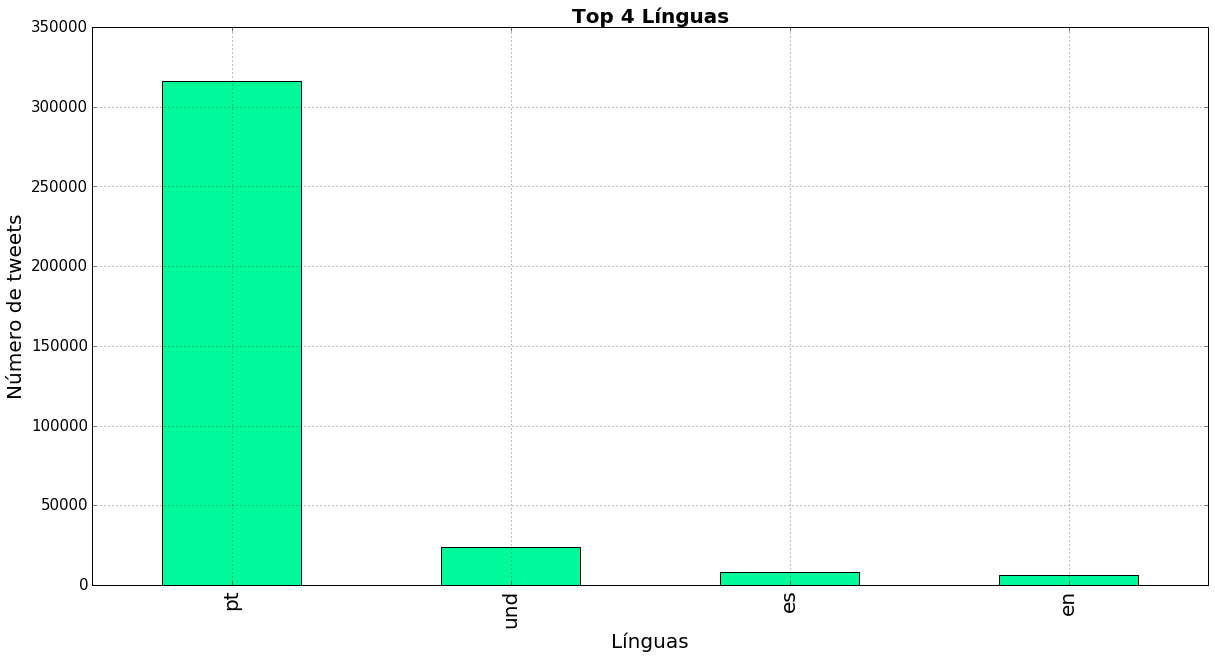

In [5]:
tweets['text'] = map(lambda tweet: tweet['text'], tweets_data)
tweets['lang'] = map(lambda tweet: tweet['lang'], tweets_data)
tweets['country'] = map(lambda tweet: tweet['place']['country']
                        if tweet['place'] != None else None, tweets_data)

tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Línguas'.decode('utf-8'), fontsize=20)
ax.set_ylabel('Número de tweets'.decode('utf-8') , fontsize=20)
ax.set_title('Top 4 Línguas'.decode('utf-8'), fontsize=20, fontweight='bold')
tweets_by_lang[:4].plot(ax=ax, kind='bar', color='mediumspringgreen')
plt.grid()

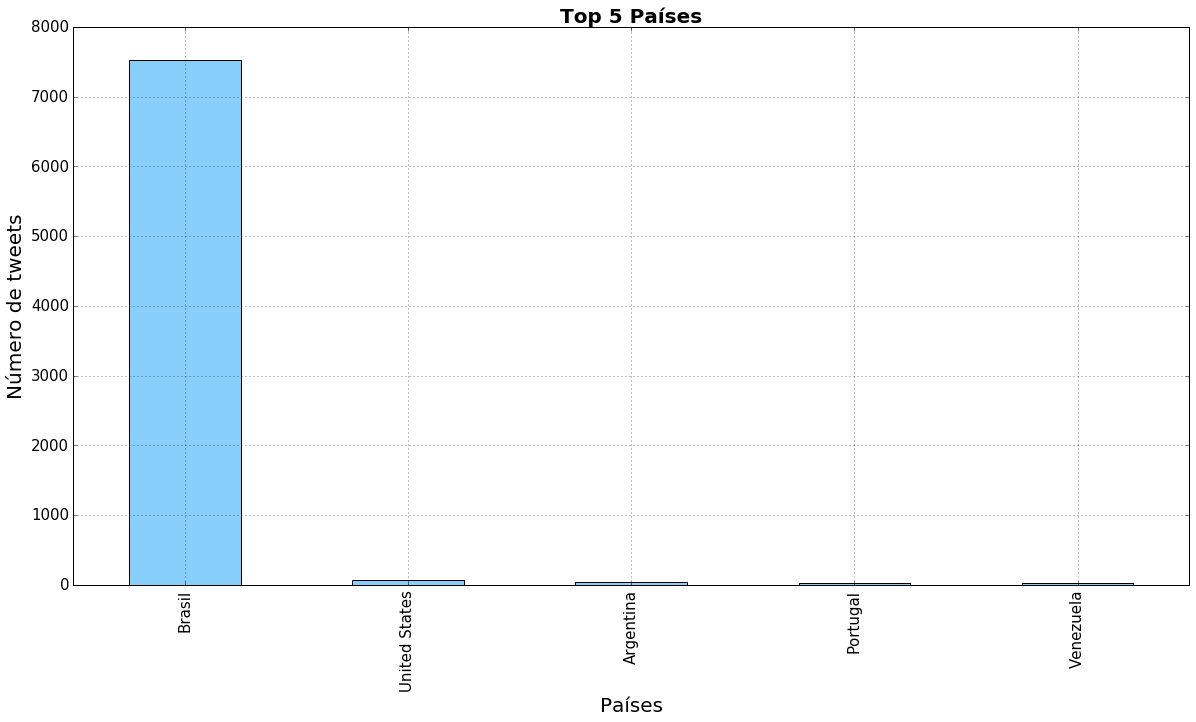

In [5]:
tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Países'.decode('utf-8'), fontsize=20)
ax.set_ylabel('Número de tweets'.decode('utf-8') , fontsize=20)
ax.set_title('Top 5 Países'.decode('utf-8'), fontsize=20, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='lightskyblue')
plt.grid()

In [6]:
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

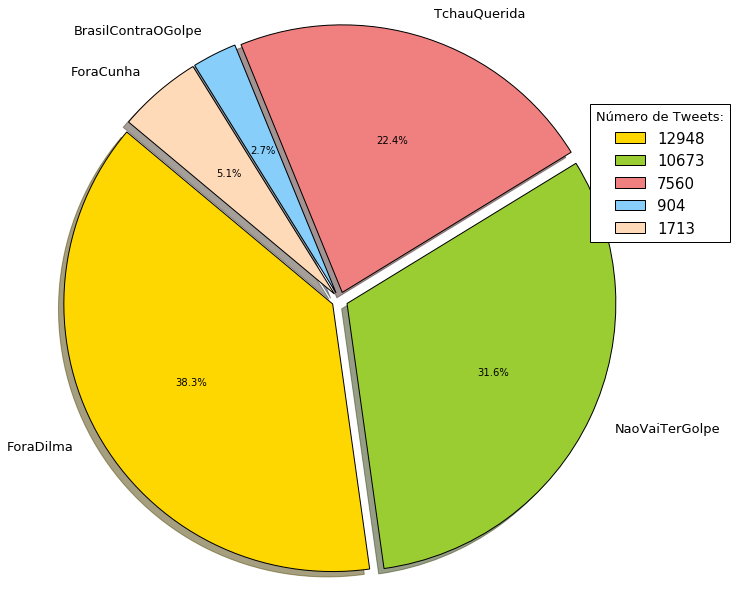

In [7]:
tweets['NaoVaiTerGolpe'] = tweets['text'].apply(lambda tweet: word_in_text('NaoVaiTerGolpe', tweet))
tweets['TchauQuerida'] = tweets['text'].apply(lambda tweet: word_in_text('TchauQuerida', tweet))
tweets['ForaDilma'] = tweets['text'].apply(lambda tweet: word_in_text('ForaDilma', tweet))
tweets['BrasilContraOGolpe'] = tweets['text'].apply(lambda tweet: word_in_text('BrasilContraOGolpe', tweet))
tweets['ForaCunha'] = tweets['text'].apply(lambda tweet: word_in_text('ForaCunha', tweet))

hashtags = ['ForaDilma', 'NaoVaiTerGolpe', 'TchauQuerida', 'BrasilContraOGolpe', 'ForaCunha']
tweets_by_hashtags = [tweets['ForaDilma'].value_counts()[True],
                      tweets['NaoVaiTerGolpe'].value_counts()[True],
                      tweets['TchauQuerida'].value_counts()[True],
                      tweets['BrasilContraOGolpe'].value_counts()[True],
                      tweets['ForaCunha'].value_counts()[True]]

plt.subplots(figsize=(10,10))
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'peachpuff']
explode = (0.03, 0.03, 0.03, 0.03, 0.03)
plt.pie(tweets_by_hashtags, explode=explode, labels=hashtags, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.rcParams['font.size'] = 15
plt.legend(tweets_by_hashtags, loc=(.95,.6), title='Número de Tweets:'.decode('utf-8'), fontsize=15)
plt.axis('equal')
plt.show()

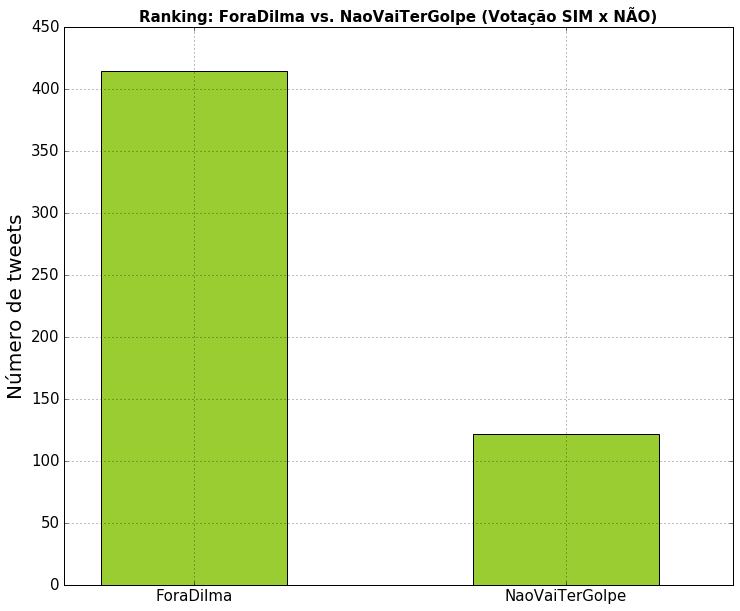

In [8]:
tweets['nao'] = tweets['text'].apply(lambda tweet: word_in_text(' nao ', tweet))
tweets['sim'] = tweets['text'].apply(lambda tweet: word_in_text(' sim ', tweet))

tweets['ImpeachmentDay'] = tweets['text'].apply(lambda tweet: word_in_text(' sim ', tweet) 
                                          or word_in_text(' nao ', tweet))

hashtags = ['ForaDilma', 'NaoVaiTerGolpe']
tweets_by_hashtags = [tweets[tweets['ImpeachmentDay'] == True]['ForaDilma'].value_counts()[True], 
                      tweets[tweets['ImpeachmentDay'] == True]['NaoVaiTerGolpe'].value_counts()[True]]


ind = np.arange(2)
width = 0.5
width2 = 0.3
x_pos = list(range(len(hashtags)))
fig, ax = plt.subplots(figsize=(12,10))
ax.bar(ind + width2, tweets_by_hashtags, width, color='yellowgreen')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Número de tweets'.decode('utf-8'), fontsize=20)
ax.set_title('Ranking: ForaDilma vs. NaoVaiTerGolpe (Votação SIM x NÃO)'.decode('utf-8'),
             fontsize=15, fontweight='bold')
ax.set_xticks([p + 1.1 * width for p in x_pos])
ax.set_xticklabels(hashtags)
plt.grid()

In [9]:
print tweets_by_hashtags

[414, 122]


In [10]:
def extract_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

tweets['link'] = tweets['text'].apply(lambda tweet: extract_link(tweet))

tweets_relevant = tweets[tweets['ImpeachmentDay'] == True]
tweets_relevant_with_link = tweets_relevant[tweets_relevant['link'] != '']

print tweets_relevant_with_link[tweets_relevant_with_link['TchauQuerida'] == True]['link']
print tweets_relevant_with_link[tweets_relevant_with_link['ForaDilma'] == True]['link']
print tweets_relevant_with_link[tweets_relevant_with_link['ForaCunha'] == True]['link']
print tweets_relevant_with_link[tweets_relevant_with_link['NaoVaiTerGolpe'] == True]['link']

8871      https://t.co/rtOavI9uQP
8906      https://t.co/VswJPAt5ul
9619      https://t.co/IiXU4ICRrH
9685      https://t.co/tlt3wTQ969
64182     https://t.co/Odd6HZPlJU
101356    https://t.co/6hOBQnYHhW
101573    https://t.co/nmY20txeMW
102084    https://t.co/9H9LU1CebE
102695    https://t.co/FdpW6olPVF
103954    https://t.co/brnPZh3Ruc
104091    https://t.co/h9SUq42jJp
105028    https://t.co/KQd41ZTwYW
105442    https://t.co/qZszc7jYNy
105724    https://t.co/I8Wv0IBzpe
106003    https://t.co/5HcF1xPBDj
110873    https://t.co/3f9crnn6Wl
112773    https://t.co/3f9crnn6Wl
116954    https://t.co/Xw8EDpB6Vp
117108    https://t.co/cjGcnmCN8J
118773    https://t.co/26T3oPIREo
119310    https://t.co/6qYZPS4ch6
119883    https://t.co/nv8TuAkWag
120311    https://t.co/f8Q8NWD5dG
120597    https://t.co/koeOCI7qwa
120850    https://t.co/sc82GUHdHp
121499    https://t.co/syaigshcm6
123385    https://t.co/eGTNFuNDMh
124877    https://t.co/dbn3M31GhS
125940    https://t.co/6jivJOttkw
128092    http

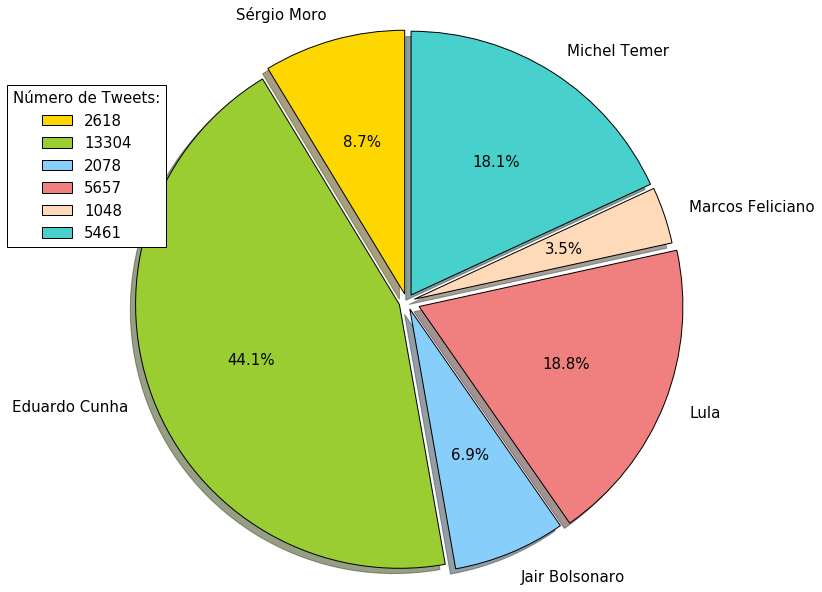

In [30]:
tweets['moro'] = tweets['text'].apply(lambda tweet: word_in_text('moro', tweet))
tweets['cunha'] = tweets['text'].apply(lambda tweet: word_in_text('cunha', tweet))
tweets['bolsonaro'] = tweets['text'].apply(lambda tweet: word_in_text('bolsonaro', tweet))
tweets['lula'] = tweets['text'].apply(lambda tweet: word_in_text('lula', tweet))
tweets['temer'] = tweets['text'].apply(lambda tweet: word_in_text('temer', tweet))
tweets['feliciano'] = tweets['text'].apply(lambda tweet: word_in_text('feliciano', tweet))

hashtags = ['Sérgio Moro'.decode('utf-8'), 'Eduardo Cunha', 'Jair Bolsonaro', 'Lula', 'Marcos Feliciano', 'Michel Temer']
tweets_by_hashtags = [tweets['moro'].value_counts()[True],
                      tweets['cunha'].value_counts()[True],
                      tweets['bolsonaro'].value_counts()[True],
                      tweets['lula'].value_counts()[True],
                      tweets['feliciano'].value_counts()[True],
                      tweets['temer'].value_counts()[True]]

plt.subplots(figsize=(10,10))
colors = ['gold', 'yellowgreen', 'lightskyblue', 'lightcoral', 'peachpuff', 'mediumturquoise']
explode = (0.03, 0.03, 0.03, 0.05, 0.03, 0.03)
plt.pie(tweets_by_hashtags, explode=explode, labels=hashtags, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.rcParams['font.size'] = 15
# plt.legend(tweets_by_hashtags, loc='best')
plt.legend(tweets_by_hashtags, loc=(-.22,.6), title='Número de Tweets:'.decode('utf-8'), fontsize=15)
plt.axis('equal')
plt.show()

In [8]:
tweets['created_at'] = map(lambda tweet: time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y')), tweets_data)
tweets['user'] = map(lambda tweet: tweet['user']['screen_name'], tweets_data)
tweets['user_followers_count'] = map(lambda tweet: tweet['user']['followers_count'], tweets_data)
tweets['retweet_count'] = map(lambda tweet: tweet['retweet_count'], tweets_data)
tweets['favorite_count'] = map(lambda tweet: tweet['favorite_count'], tweets_data)

tweets['text'] = map(lambda tweet: tweet['text'].encode('utf-8'), tweets_data)
tweets['lang'] = map(lambda tweet: tweet['lang'], tweets_data)
tweets['Location'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data)

tweets.head()

,text,lang,country,created_at,user,user_followers_count,retweet_count,favorite_count,Location
0,"RT @GringaBrazilien: Bom Dia Brasil, #Impeachm...",pt,None,2016-04-17 15:15:21,exxonre,28,0,0,None
1,RT @marisascruz: NOSSO HINO!\nNOSSA BANDEIRA!\...,pt,None,2016-04-17 15:15:21,DetritoFederal1,2428,0,0,None
2,"RT @GarotaCiume: Não sou petista, só não sou c...",pt,None,2016-04-17 15:15:21,Souzaa_mih1,433,0,0,None
3,#ThauQuerida #ImpeachmentDay,und,Brasil,2016-04-17 15:15:21,italo_filho,42,0,0,Brasil
4,RT @luadacamz: Eu quero Impeachment desse calo...,pt,None,2016-04-17 15:15:22,camzminhao,443,0,0,None


In [9]:
list_of_original_tweets = [element for element in tweets['text'].values if not element.startswith('RT')]

print "Número de Tweets originais : " + str(len(list_of_original_tweets))

list_of_retweets = [element for element in tweets['text'].values if element.startswith('RT')]
print "Número de Retweets : " + str(len(list_of_retweets))

Número de Tweets originais : 100025
Número de Retweets : 258268


In [14]:
def plot_tweets_per_category(category, title, x_title, y_title, top_n=5, output_filename="plot.png"):
    tweets_by_cat = category.value_counts()
    fig, ax = plt.subplots(figsize=(20,10))
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)
    tweets_by_cat[:top_n].plot(ax=ax, kind='bar', color='mediumturquoise')
    fig.savefig(output_filename)
    fig.show()

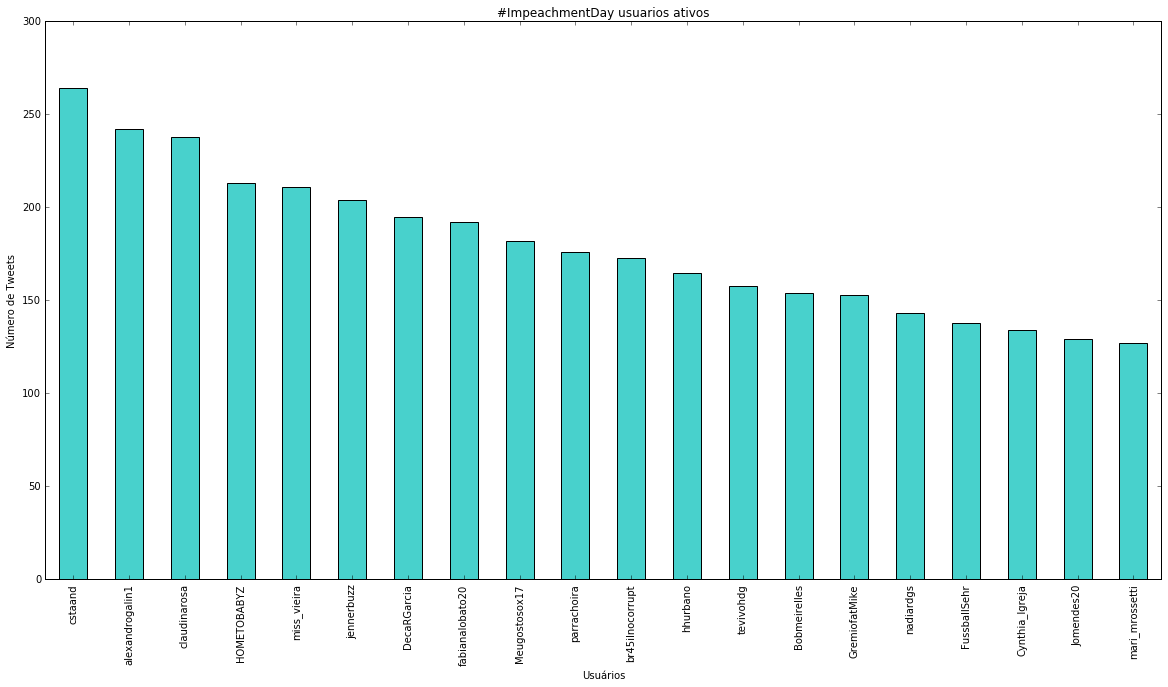

In [15]:
plot_tweets_per_category(tweets['user'], 
                             "#ImpeachmentDay usuarios ativos", 
                             "Usuários".decode('utf-8'), 
                             "Número de Tweets".decode('utf-8'), 20)

### Wordcloud (ajustar)
É necessário configurar as *stopwords*

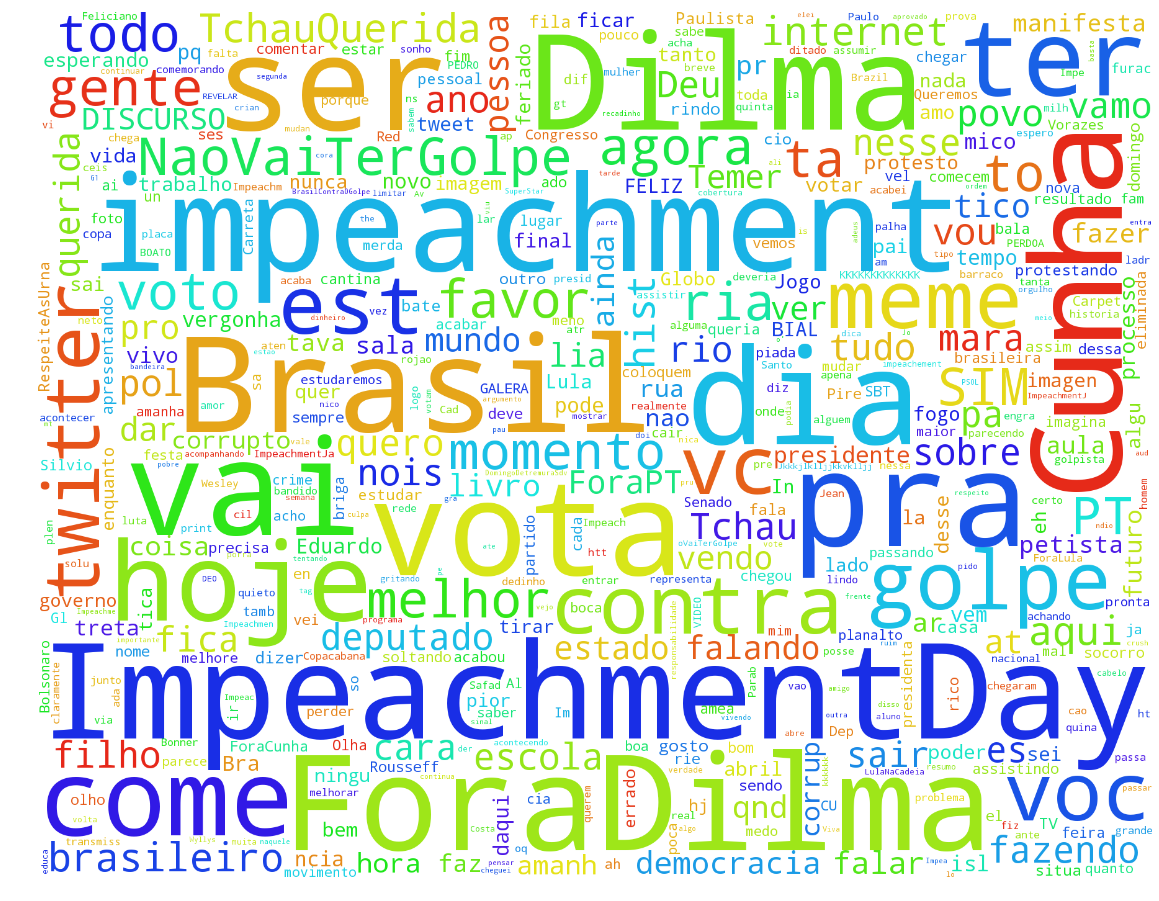

In [22]:
text = " ".join(tweets['text'].values.astype(str))

no_urls_no_tags = " ".join([word for word in text.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

punctuation = list(string.punctuation)
stop = nltk.corpus.stopwords.words('portuguese') + punctuation
wordcloud = WordCloud(background_color="white", max_words=500,
                      stopwords=stop, width=1800, height=1400).generate(no_urls_no_tags)

plt.figure(figsize=(20,20))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

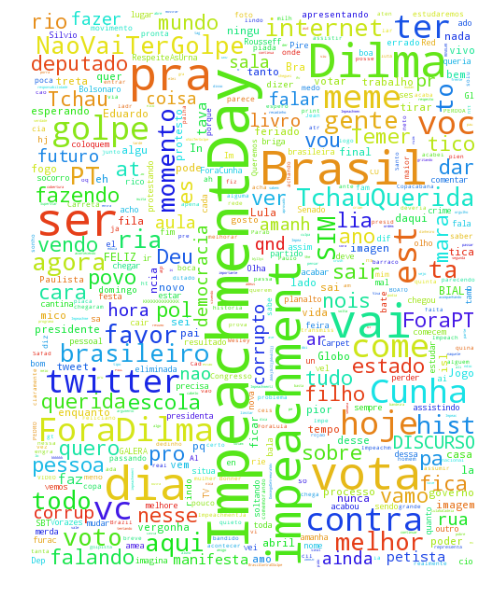

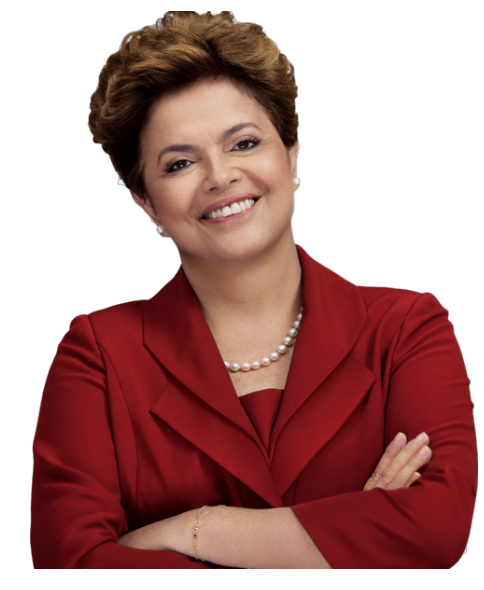

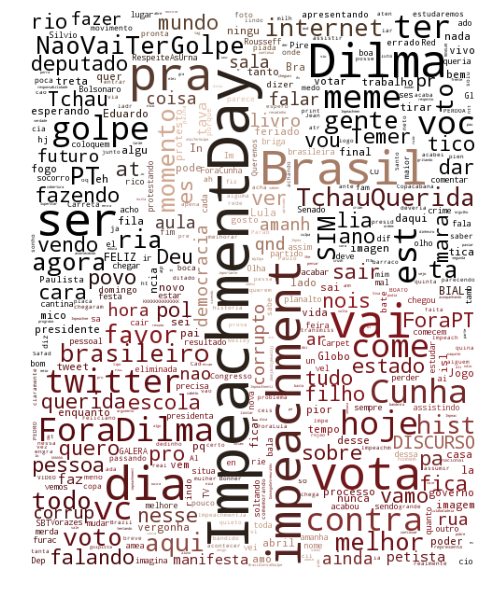

In [27]:
text = " ".join(tweets['text'].values.astype(str))

no_urls_no_tags = " ".join([word for word in text.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

tweet_coloring = imread(path.join("dilma.png"))

punctuation = list(string.punctuation)
stop = nltk.corpus.stopwords.words('portuguese') + punctuation
wordcloud = WordCloud(background_color="white", max_words=500, mask=tweet_coloring,
                      stopwords=stop, width=1800, height=1400).generate(no_urls_no_tags)

plt.figure(figsize=(10,10))
image_colors = ImageColorGenerator(tweet_coloring)
plt.imshow(wordcloud)
plt.axis("off")
plt.figure(figsize=(10,10))
plt.imshow(tweet_coloring, cmap=plt.cm.gray)
plt.axis("off")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis("off")
plt.show()

* * *
* * *

### Mapa (ajustar)

In [2]:
tweets = pd.read_json("data/small-data-fixed.json")
print 'OK!'
type(tweets)

OK!


pandas.core.frame.DataFrame

In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358293 entries, 0 to 358292
Data columns (total 31 columns):
contributors                 0 non-null float64
coordinates                  470 non-null object
created_at                   358293 non-null datetime64[ns]
entities                     358293 non-null object
extended_entities            164504 non-null object
favorite_count               358293 non-null int64
favorited                    358293 non-null bool
filter_level                 358293 non-null object
geo                          470 non-null object
id                           358293 non-null int64
id_str                       358293 non-null int64
in_reply_to_screen_name      4820 non-null object
in_reply_to_status_id        3303 non-null float64
in_reply_to_status_id_str    3303 non-null float64
in_reply_to_user_id          4820 non-null float64
in_reply_to_user_id_str      4820 non-null float64
is_quote_status              358293 non-null bool
lang                

In [68]:
coordinate = []
for col in tweets['coordinates'][~tweets['coordinates'].isnull()]:
    coord = col['coordinates'][::-1]
#     coord = col['coordinates']
    coordinate.append(coord)
    
print coordinate[10]

[-20.32700724, -40.33692957]


In [69]:
coord_text = []
for col in tweets['text'][~tweets['coordinates'].isnull()]:
    coord = col.encode('utf-8')
    coord_text.append(coord)
    
print coord_text[10]

Que seja feita a vontade de Deus! 🙏🏻😊😘

#boatarde #sejafeitaavontadededeus #foradilma #forapt… https://t.co/NrWCuYNQ8B


In [7]:
tweets[['coordinates','text']][~tweets['coordinates'].isnull()].head(11)

,coordinates,text
96,"{u'type': u'Point', u'coordinates': [-43.98846...","@ApyusCom Isso vai ser muito, muito legal! Tô ..."
257,"{u'type': u'Point', u'coordinates': [-44.07219...",Que o principado da corrupção seja extinto do ...
598,"{u'type': u'Point', u'coordinates': [-49.94293...","Esse papo de ""impiechment é golpe"" é tão verda..."
1428,"{u'type': u'Point', u'coordinates': [-47.9287,...",1. #ImpeachmentDay\n2. Leicester\n3. #DomingoD...
1572,"{u'type': u'Point', u'coordinates': [-47.88279...",é hoje Pátria Amada ✌ #pazeamor #impeachment #...
1615,"{u'type': u'Point', u'coordinates': [-9.1413, ...",6. Benfica B\n7. Porto B\n8. #EquipaB\n9. #Imp...
1701,"{u'type': u'Point', u'coordinates': [-43.98848...",Saindo...\r É agora ou nunca! Pena q n tem @lo...
1723,"{u'type': u'Point', u'coordinates': [-47.89916...",Brasília ta fervendo hoje contra o golpe! #juv...
3149,"{u'type': u'Point', u'coordinates': [-43.17408...",#naovaitergolpe @ Praia De Copacabana https://...
3346,"{u'type': u'Point', u'coordinates': [-43.17109...",#naovaitergolpe @ Praia do Leme https://t.co/g...


In [70]:
coords = tweets['coordinates']
coords = coords[~coords.isnull()]
coords = coords.apply(lambda d: d['coordinates'][::-1])
coords.head(20)

96      [-19.83755667, -43.98846667]
257       [-22.4835006, -44.0721959]
598       [-22.2458872, -49.9429378]
1428            [-15.7785, -47.9287]
1572    [-15.79442326, -47.88279271]
1615              [38.9901, -9.1413]
1701       [-19.83754, -43.98848333]
1723        [-15.7835, -47.89916389]
3149    [-22.96394383, -43.17408138]
3346          [-22.96423, -43.17109]
3594    [-20.32700724, -40.33692957]
4338      [-21.6855632, -43.3545121]
4510      [-29.6890964, -51.1366438]
4537    [-22.88908811, -43.43264018]
4886        [-29.68912, -51.1366868]
6737              [19.0728, 72.8826]
7284    [-23.65133278, -46.75984952]
7351            [-19.9319, -44.0539]
7611      [-20.9308903, -54.9694217]
7851      [-25.6440025, -49.3246874]
Name: coordinates, dtype: object

In [71]:
m = folium.Map([-14,-53.25], zoom_start=4)

for x, text in enumerate(coord_text):
    folium.Marker(coordinate[x], popup=str(coordinate[x])).add_to(m)

m

In [10]:
tweets.text.head()

0    RT @GringaBrazilien: Bom Dia Brasil, #Impeachm...
1    RT @marisascruz: NOSSO HINO!\nNOSSA BANDEIRA!\...
2    RT @GarotaCiume: Não sou petista, só não sou c...
3                         #ThauQuerida #ImpeachmentDay
4    RT @luadacamz: Eu quero Impeachment desse calo...
Name: text, dtype: object

### Picos de Horários: (ajustar)

In [11]:
tweets['created_at'] = pd.to_datetime(pd.Series(tweets['created_at']))

tweets.set_index('created_at', drop=False, inplace=True)

tweets.index = tweets.index.tz_localize('GMT')
tweets.index = tweets.index - DateOffset(hours = 3)
tweets.index

tweets.head()

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,filter_level,geo,id,...,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user
created_at,,,,,,,,,,,,,,,,,,,,,
2016-04-17 12:15:21+00:00,NaN,None,2016-04-17 15:15:21,"{u'user_mentions': [{u'id': 2294780467, u'indi...","{u'media': [{u'source_user_id': 2294780467, u'...",0,False,low,None,721718699565178880,...,NaN,NaN,0,False,"{u'contributors': None, u'truncated': False, u...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...","RT @GringaBrazilien: Bom Dia Brasil, #Impeachm...",2016-04-17 15:15:21.518,False,"{u'follow_request_sent': None, u'profile_use_b..."
2016-04-17 12:15:21+00:00,NaN,None,2016-04-17 15:15:21,"{u'user_mentions': [{u'id': 87843887, u'indice...",NaN,0,False,low,None,721718699288342528,...,NaN,NaN,0,False,"{u'contributors': None, u'truncated': False, u...","<a href=""http://twitter.com/download/android"" ...",RT @marisascruz: NOSSO HINO!\nNOSSA BANDEIRA!\...,2016-04-17 15:15:21.452,False,"{u'follow_request_sent': None, u'profile_use_b..."
2016-04-17 12:15:21+00:00,NaN,None,2016-04-17 15:15:21,"{u'user_mentions': [{u'id': 206181302, u'indic...",NaN,0,False,low,None,721718699418202112,...,NaN,NaN,0,False,"{u'contributors': None, u'truncated': False, u...","<a href=""http://twitter.com/download/android"" ...","RT @GarotaCiume: Não sou petista, só não sou c...",2016-04-17 15:15:21.483,False,"{u'follow_request_sent': None, u'profile_use_b..."
2016-04-17 12:15:21+00:00,NaN,None,2016-04-17 15:15:21,"{u'user_mentions': [], u'symbols': [], u'hasht...",NaN,0,False,low,None,721718700496273408,...,NaN,NaN,0,False,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",#ThauQuerida #ImpeachmentDay,2016-04-17 15:15:21.740,False,"{u'follow_request_sent': None, u'profile_use_b..."
2016-04-17 12:15:22+00:00,NaN,None,2016-04-17 15:15:22,"{u'user_mentions': [{u'id': 409967714, u'indic...",NaN,0,False,low,None,721718702153023488,...,NaN,NaN,0,False,"{u'contributors': None, u'truncated': False, u...","<a href=""http://twitter.com/download/android"" ...",RT @luadacamz: Eu quero Impeachment desse calo...,2016-04-17 15:15:22.135,False,"{u'follow_request_sent': None, u'profile_use_b..."


In [12]:
tweets30s = tweets['created_at'].resample('1h', how='count')
tweets30s.head()

created_at
2016-04-17 12:00:00+00:00    11536
2016-04-17 13:00:00+00:00     9286
2016-04-17 14:00:00+00:00    97672
2016-04-17 15:00:00+00:00    78594
2016-04-17 16:00:00+00:00    43528
Freq: H, Name: created_at, dtype: int64

In [13]:
avg = tweets30s.mean()

vincent.core.initialize_notebook()
area = vincent.Area(tweets30s)
area.colors(brew='Spectral')
area.display()